c:\Users\bento\gis582\project\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


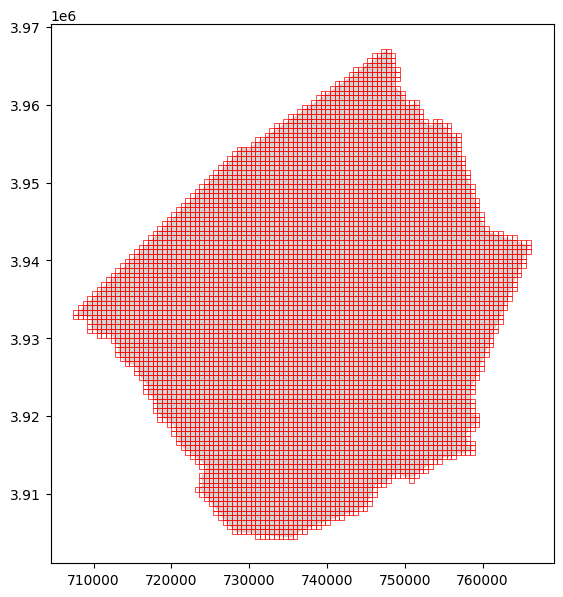

In [1]:
import os
import sys

sys.path.append("../model")
sys.path.append("..")

import math
import geopandas as gpd
import numpy as np
import pystac_client
import planetary_computer
import rioxarray
import xarray as xr
import rasterio
import rasterio.plot
import rasterio.warp
from rasterio.enums import Resampling
from rasterio.merge import merge
from rasterio.windows import from_bounds
# import stackstac
from tqdm import tqdm
import glob
from shapely.geometry import box, mapping
from datetime import datetime
import heapq
import torch
import yaml
from box import Box
from shapely.geometry import Point
import matplotlib.pyplot as plt
from sklearn import decomposition
from torchvision.transforms import v2
from src.model import ClayMAEModule

# Define your data directory and tile size
tiles_data_dir = "../data/tiles_gdb"
if not os.path.exists(tiles_data_dir):
    os.mkdir(tiles_data_dir)

tiles_geojson_path = "../data/tiles.geojson"
tile_size = 600

# TO BE REMOVED
if os.path.exists(tiles_geojson_path):
    os.remove(tiles_geojson_path)

county_boundary = gpd.read_file("../data/county_boundary.shp")
# Reproject to EPSG:32617 (UTM Zone 17N), which is the CRS used by 
# Sentinel-2 images in this region
if county_boundary.crs != 32617:
    county_boundary = county_boundary.to_crs("EPSG:32617")
    county_boundary.to_file("../data/county_boundary.shp")

minx, miny, maxx, maxy = county_boundary.total_bounds

# Adjust the bounds so that they align with the tile size
# For minx and miny, floor to the nearest multiple of tile_size
minx = math.floor(minx / tile_size) * tile_size
miny = math.floor(miny / tile_size) * tile_size
# For maxx and maxy, ceil to the nearest multiple of tile_size
maxx = math.ceil(maxx / tile_size) * tile_size
maxy = math.ceil(maxy / tile_size) * tile_size

# Generate tiles (i.e., bounding boxes in the format of xmin, ymin, xmax, ymax) 
# to fill the county boundary. If it overlaps the edge, extend outside (rather 
# than coming up short within the boundary), to ensure full coverage
# Get the bounds of the county boundary

if not os.path.exists(tiles_geojson_path):
    # Generate the grid of tiles
    all_tiles = []
    x_coords = np.arange(minx, maxx, tile_size)
    y_coords = np.arange(miny, maxy, tile_size)

    for x in x_coords:
        for y in y_coords:
            # Create a box for each tile
            tile = box(x, y, x + tile_size, y + tile_size)
            all_tiles.append(tile)
    # Create a GeoDataFrame for the tiles
    tiles_gdf = gpd.GeoDataFrame({'geometry': all_tiles}, crs=county_boundary.crs)
    # Keep only tiles that intersect the county, but keep their full geometry
    tiles_gdf = tiles_gdf[tiles_gdf.geometry.intersects(county_boundary.union_all())]\
        .reset_index(drop=True)
    # Remove duplicate tiles
    tiles_gdf = tiles_gdf.drop_duplicates()
    # Add columns for tracking satellite data
    tiles_gdf['processed'] = False
    tiles_gdf['data_files'] = [[] for _ in range(len(tiles_gdf))]
    # Save tiles_gdf to GeoJSON
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')
else:
    tiles_gdf = gpd.read_file(tiles_geojson_path)

# Generate raster and shapefile masks that match the external 
# bounds (and crs) of all of the tiles since it will not perfectly align with 
# the original boundary


# Create a unified boundary from all the tiles
tiles_union = tiles_gdf.union_all()

# Save the unified tiles boundary as a shapefile mask
tiles_union_gdf = gpd.GeoDataFrame(geometry=[tiles_union], crs=tiles_gdf.crs)
tiles_union_shapefile_path = "../data/tiles_union_mask.shp"
tiles_union_gdf.to_file(tiles_union_shapefile_path)

# Create a raster mask matching the external bounds and CRS of all tiles
# Define the raster properties
minx_tiles, miny_tiles, maxx_tiles, maxy_tiles = tiles_union.bounds
pixel_size = 10  # Pixel size in meters (adjust as needed)

# Calculate the number of rows and columns
ncols = int((maxx_tiles - minx_tiles) / pixel_size)
nrows = int((maxy_tiles - miny_tiles) / pixel_size)

# Define the transform for the raster
transform = rasterio.transform.from_origin(minx_tiles, maxy_tiles, 
                                           pixel_size, pixel_size)

# Define the raster metadata
raster_meta = {
    'driver': 'GTiff',
    'height': nrows,
    'width': ncols,
    'count': 1,
    'dtype': 'uint8',
    'crs': tiles_gdf.crs,
    'transform': transform
}

# Path to save the raster mask
raster_mask_path = "../data/tiles_union_mask.tif"

# Create the raster mask
with rasterio.open(raster_mask_path, 'w', **raster_meta) as out_raster:
    # Burn the unified tiles geometry into the raster
    shapes = [(tiles_union, 1)]
    burned = rasterio.features.rasterize(
        shapes,
        out_shape=(nrows, ncols),
        transform=transform,
        fill=0,
        all_touched=True,
        dtype='uint8'
    )
    out_raster.write_band(1, burned)

# Visualize the tiles and vectors (optional)
ax = county_boundary.plot(color='lightgray', figsize=(7, 7))
tiles_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
plt.show()

In [2]:
print(f"The data region is sub-divided into {len(tiles_gdf)} distinct tiles.")

# Calculate the width and height of each tile
tiles_gdf['width'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxx - row.minx, axis=1)
tiles_gdf['height'] = tiles_gdf.geometry.bounds.apply(lambda row: row.maxy - row.miny, axis=1)

# Check if all tiles have the same width and height
unique_widths = tiles_gdf['width'].unique()
unique_heights = tiles_gdf['height'].unique()

if len(unique_widths) == 1 and len(unique_heights) == 1:
    print(f"All tiles have uniform size: width = {unique_widths[0]} meters, height = {unique_heights[0]} meters.")
else:
    print("Tiles have varying sizes:")
    print(tiles_gdf[['width', 'height']])


The data region is sub-divided into 5954 distinct tiles.
All tiles have uniform size: width = 600.0 meters, height = 600.0 meters.


In [3]:
# Urban Imperviousness Data - https://www.sciencebase.gov/catalog/item/604a500ed34eb120311b006c

# Path to urban imperviousness data
ui2016_path = "D:/data/nlcd_2016_impervious_l48_20210604/nlcd_2016_impervious_l48_20210604.img"

urban_data_dir = "../data/urban_gdb"
if not os.path.exists(urban_data_dir):
    os.mkdir(urban_data_dir)

def urban_file_name(year, data_dir):
    return os.path.join(data_dir, f"nlcd_impervious_{year}.tif")

def extract_urban_by_year_tile_by_tile(ui_path, year, tiles_gdf, urban_data_dir="../data/urban_gdb", 
                                       target_resolution=10):
    """
    Process and extract urban imperviousness data for each tile to avoid memory errors and resample to target resolution.

    Parameters:
    - ui_path (str): Path to the urban imperviousness raster data.
    - year (int): Year of the data (used for naming purposes).
    - tiles_gdf (GeoDataFrame): GeoDataFrame containing the tiles.
    - urban_data_dir (str): Directory to save the urban imperviousness tiles.
    - target_resolution (int): Target resolution for resampling, in meters (default is 10m).

    Returns:
    - tiles_gdf (GeoDataFrame): Updated GeoDataFrame with paths to the urban imperviousness tiles.
    """
    # Ensure the output directory exists
    if not os.path.exists(urban_data_dir):
        os.makedirs(urban_data_dir)

    # Reproject tiles_gdf to match the CRS of the urban imperviousness data
    with rasterio.open(ui_path) as ui_dataset:
        ui_crs = ui_dataset.crs
    tiles_gdf_ui_crs = tiles_gdf.to_crs(ui_crs)

    # Add a new column in tiles_gdf for the urban imperviousness tile path if it doesn't exist
    if 'ui_tile_path' not in tiles_gdf.columns:
        tiles_gdf['ui_tile_path'] = None

    for idx, tile in tiles_gdf_ui_crs.iterrows():
        # Check if the tile has already been processed
        ui_tile_filename = f"ui_tile_{year}_{idx}.tif"
        ui_tile_path = os.path.join(urban_data_dir, ui_tile_filename)
        if os.path.exists(ui_tile_path):
            # Update the tiles_gdf
            tiles_gdf.at[idx, 'ui_tile_path'] = ui_tile_path
            continue
        
        # Get the tile bounds
        minx, miny, maxx, maxy = tile.geometry.bounds

        # Open the dataset within the loop
        with rasterio.open(ui_path) as ui_dataset:
            # Define the window to read
            window = from_bounds(minx, miny, maxx, maxy, transform=ui_dataset.transform)

            # Read the data within the window
            try:
                ui_tile_data = ui_dataset.read(1, window=window)
            except ValueError:
                print(f"No data for tile {idx}")
                continue

            # Check if the tile contains data
            if np.all(ui_tile_data == ui_dataset.nodata):
                print(f"No data in tile {idx}")
                continue

            # Define the transform for the tile
            tile_transform = ui_dataset.window_transform(window)

            # Calculate the resampling scale factors for both dimensions
            scale_x = ui_dataset.res[0] / target_resolution
            scale_y = ui_dataset.res[1] / target_resolution

            # Create a destination array for the resampled data
            dest_shape = (
                int(ui_tile_data.shape[0] * scale_y),
                int(ui_tile_data.shape[1] * scale_x)
            )
            dest_array = np.empty(dest_shape, dtype=ui_tile_data.dtype)

            # Reproject and resample to the target resolution
            rasterio.warp.reproject(
                source=ui_tile_data,
                destination=dest_array,
                src_transform=tile_transform,
                src_crs=ui_dataset.crs,
                dst_transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
                dst_crs=ui_dataset.crs,
                resampling=Resampling.bilinear  # Choose the resampling method
            )

        # Save the resampled tile to a GeoTIFF
        with rasterio.open(
            ui_tile_path,
            'w',
            driver='GTiff',
            height=dest_array.shape[0],
            width=dest_array.shape[1],
            count=1,
            dtype=dest_array.dtype,
            crs=ui_dataset.crs,
            transform=rasterio.transform.from_origin(minx, maxy, target_resolution, target_resolution),
            nodata=ui_dataset.nodata
        ) as dst:
            dst.write(dest_array, 1)

        # Update the tiles_gdf
        tiles_gdf.at[idx, 'ui_tile_path'] = ui_tile_path

    # Reproject tiles_gdf back to its original CRS if necessary
    tiles_gdf = tiles_gdf.to_crs(tiles_gdf.crs)

    # Save the updated tiles_gdf
    tiles_geojson_path = "../data/tiles.geojson"
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

    return tiles_gdf


tiles_gdf = extract_urban_by_year_tile_by_tile(
    ui_path=ui2016_path,
    year=2016,
    tiles_gdf=tiles_gdf,
    urban_data_dir=urban_data_dir
)
# Save the updated tiles_gdf to 'tiles.geojson'
tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

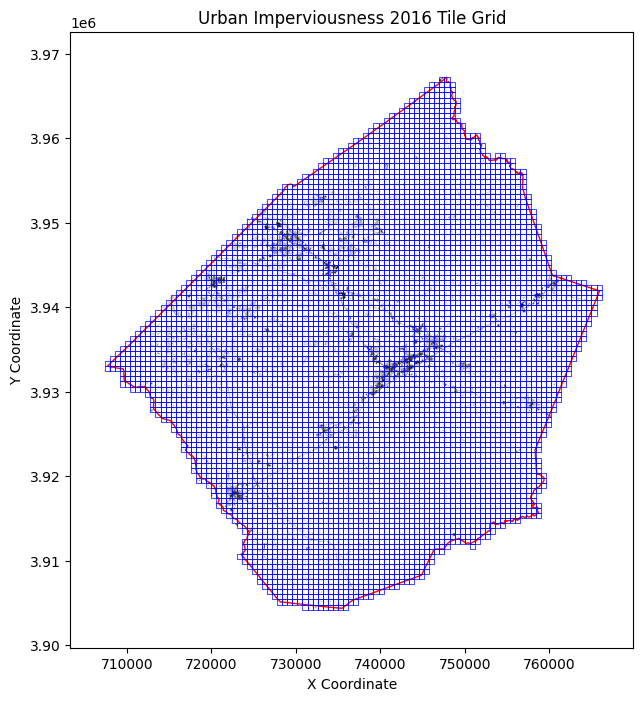

In [4]:
# Paths and variables
mosaic_path = os.path.join("../data", "urban_imperviousness.tif")

# CRS to match (assuming both county_boundary and tiles_gdf have the same CRS)
target_crs = county_boundary.crs

if not os.path.exists(mosaic_path):
    # Get the list of urban imperviousness tile paths
    tile_paths = tiles_gdf['ui_tile_path'].dropna().tolist()

    # List to hold rasterio datasets
    src_files_to_mosaic = []

    # Read each tile and append to the list
    for fp in tile_paths:
        src = rasterio.open(fp)
        src_files_to_mosaic.append(src)

    # Merge the tiles into a mosaic
    mosaic_array, out_trans = merge(src_files_to_mosaic)

    # Close the individual datasets
    for src in src_files_to_mosaic:
        src.close()

    # Get metadata from one of the source files (they should all be the same)
    with rasterio.open(tile_paths[0]) as src0:
        out_meta = src0.meta.copy()

    # Update the metadata to reflect the mosaic dimensions and transform
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic_array.shape[1],
        "width": mosaic_array.shape[2],
        "transform": out_trans,
        "crs": src0.crs  # This is the original CRS of the mosaic
    })

    # Reproject the mosaic array to the target CRS (county_boundary and tiles_gdf CRS)
    dst_array, dst_transform = rasterio.warp.reproject(
        source=mosaic_array,
        src_crs=out_meta['crs'],
        src_transform=out_trans,
        dst_crs=target_crs,  # Target CRS from county_boundary and tiles_gdf
        dst_transform=None,  # Let rasterio calculate the new transform
        resampling=rasterio.enums.Resampling.bilinear  # Choose appropriate resampling method
    )

    # Update metadata to reflect the new dimensions and CRS after reprojection
    out_meta.update({
        "height": dst_array.shape[1],
        "width": dst_array.shape[2],
        "transform": dst_transform,
        "crs": target_crs
    })

    # Save the reprojected mosaic to a file
    with rasterio.open(mosaic_path, "w", **out_meta) as dest:
        dest.write(dst_array)
    
    # Open the saved reprojected mosaic
    mosaic = rasterio.open(mosaic_path)
else:
    # Open the mosaic from file
    mosaic = rasterio.open(mosaic_path)

# Read the data from the mosaic
data = mosaic.read(1)  # Read the first band

# Plot the mosaic
fig, ax = plt.subplots(figsize=(8, 8))

# Use mosaic.transform for the transform parameter
rasterio.plot.show(data, transform=mosaic.transform, ax=ax, cmap='gray_r')

# Plot the county boundary and tile boundaries
county_boundary.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
tiles_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=0.5)

plt.title('Urban Imperviousness 2016 Tile Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [ ]:

def remove_small_files(directory, min_size_kb):
    """
    Remove all files from the directory that are smaller than min_size_kb kilobytes.

    Parameters:
    directory (str): The path to the directory.
    min_size_kb (int or float): The minimum size of the file in kilobytes. Files smaller than this will be removed.
    """
    # Convert kilobytes to bytes
    min_size_bytes = min_size_kb * 1024
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        
        # Check if it's a file
        if os.path.isfile(file_path):
            # Get the file size in bytes
            file_size = os.path.getsize(file_path)
            
            # Remove the file if it's smaller than the threshold
            if file_size < min_size_bytes:
                os.remove(file_path)
                print(f"Removed: {filename}, Size: {file_size / 1024:.2f} KB")

def remove_newest_files(directory, n):
    """
    Remove up to n of the newest files from the specified directory.

    Parameters:
    directory (str): The path to the directory.
    n (int): The number of newest files to remove.
    """
    # Get a list of all files in the directory with their modification times
    files_with_times = [
        (os.path.join(directory, filename), os.path.getmtime(os.path.join(directory, filename)))
        for filename in os.listdir(directory)
        if os.path.isfile(os.path.join(directory, filename))
    ]
    
    # Sort the files by their modification time (newest first)
    newest_files = heapq.nlargest(n, files_with_times, key=lambda x: x[1])

    # Remove up to n of the newest files
    for file_path, mod_time in newest_files:
        os.remove(file_path)
        print(f"Removed: {os.path.basename(file_path)}, Modified on: {datetime.fromtimestamp(mod_time)}")

# Clean up files where they did not download all the way, or where the connection may have been interrupted.
remove_small_files(tiles_data_dir, 10)
remove_newest_files(tiles_data_dir, 5)

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)
query = {"eo:cloud_cover": {"lt": 1}}

collections=["sentinel-2-l2a"]

# Dates to query
start = "2016-01-01"
end = "2024-08-31"

# Bands to query:
#  B02 (Blue) - 490 nm (10 m resolution)
#      Useful for water body delineation and identifying vegetation.
#  B03 (Green) - 560 nm (10 m resolution)
#      Useful for vegetation monitoring.
#  B04 (Red) - 665 nm (10 m resolution)
#      Useful for vegetation and crop health monitoring (e.g., chlorophyll absorption).
#  B08 (Near Infrared - NIR) - 842 nm (10 m resolution)
#      Key band for calculating NDVI and monitoring vegetation health.
bands = ["B02", "B03", "B04", "B08"]
bands_map = {"B02": "blue", "B03": "green", "B04": "red", "B08": "nir"}

# GSD (in meters)
gsd = 10

epsg = 32617

# Function to query STAC items for a tile
def query_stac_tile(tile_geometry, catalog, start, end, 
                    query, collections=["sentinel-2-l2a"], 
                    limit=1000):
    # Get the bounds of the tile in WGS84
    tile_wgs84 = gpd.GeoSeries([tile_geometry], crs="EPSG:32617").to_crs("EPSG:4326").iloc[0]
    minx, miny, maxx, maxy = tile_wgs84.bounds
    bbox = [minx, miny, maxx, maxy]

    # Perform the search
    search = catalog.search(
        collections=collections,
        bbox=bbox,
        datetime=f"{start}/{end}",
        limit=limit,
        query=query
    )
    # Get the items from the search results
    items = list(search.item_collection())
    return items

def get_subregion(dataset, bounds):
    min_x, min_y, max_x, max_y = bounds
    # Subset the dataset using xarray's sel function
    subregion = dataset.sel(
        x=slice(min_x, max_x),  # X-coordinate bounds
        y=slice(max_y, min_y)   # Y-coordinate bounds (flip due to coordinate system)
    )
    return subregion

# Function to get images from item
def get_images_from_item(item, bands, output_file_path, 
                         chunk_size=2048, dtype=np.float32, 
                         crs="EPSG:32617", bounds=None):
    # Check if the file already exists
    if not os.path.exists(output_file_path):

        band_datasets = []
        # Loop through bands and collect data
        for band in bands:
            # Sign the asset URLs
            asset_href = planetary_computer.sign(item.assets[band].href)
            # Open the image using rioxarray
            with rasterio.Env():
                ds = rioxarray.open_rasterio(
                    asset_href,
                    chunks={"band": -1, "x": chunk_size, "y": chunk_size},
                    lock=False
                ).astype(dtype)
                if ds.rio.crs != crs:
                    ds = ds.rio.reproject(
                        crs, 
                        resampling=Resampling.nearest,
                        num_threads=2
                    )
                if bounds is not None:
                    ds = get_subregion(ds, bounds)
                band_datasets.append(ds)

        # Stack bands into a single dataset
        stacked_ds = xr.concat(band_datasets, dim='band')

        # Store time as an attribute
        naive_datetime = item.datetime.replace(tzinfo=None)
        time_value = np.datetime64(naive_datetime, 'ns')
        stacked_ds.attrs['time'] = str(time_value)
        
        # Save the stacked dataset to a single GeoTIFF file
        # stacked_ds.rio.to_raster(output_file_path)
        # Write the data using Dask and rioxarray, with windowed=True and tiled=True
        with rasterio.Env(GDAL_CACHEMAX=512):  # Set cache size to 512 MB
            stacked_ds.rio.to_raster(
                output_file_path,
                tiled=True,
                windowed=True,
                blockxsize=256,
                blockysize=256,
                compress="deflate",
                num_threads=2,
                bigtiff='yes'
            )
    return output_file_path

# Function to clean up bounds for filename
def clean_bounds(bounds):
    minx, miny, maxx, maxy = bounds
    # Round to 3 decimal places and remove any special characters
    minx_str = f"{minx:.3f}".replace('.', '_')
    miny_str = f"{miny:.3f}".replace('.', '_')
    maxx_str = f"{maxx:.3f}".replace('.', '_')
    maxy_str = f"{maxy:.3f}".replace('.', '_')
    # Combine into a single string
    bounds_str = f"{minx_str}_{miny_str}_{maxx_str}_{maxy_str}"
    return bounds_str

# Now process the tiles
for idx, tile in tiles_gdf[~tiles_gdf['processed']].iterrows():
    try:
        print(f"Processing tile {idx + 1}/{len(tiles_gdf)}")
        tile_geometry = tile['geometry']
        # Query STAC items for the tile
        tile_items = query_stac_tile(tile_geometry, catalog, start, end, 
                        query, collections=collections)
        if tile_items:
            # Collect unique items per date
            unique_items = {}
            for item in tile_items:
                date_str = item.datetime.date().isoformat()
                if date_str not in unique_items:
                    unique_items[date_str] = item
            # Process each unique item
            tile_data_files = []
            tile_bounds = tile_geometry.bounds
            # Clean up the bounds to be suitable for filename
            bounds_str = clean_bounds(tile_bounds)
            # Initialize tqdm progress bar
            with tqdm(total=len(unique_items), 
                      desc=f"Tile {idx}: Processing dates", 
                      unit=" date", 
                      leave=False) as pbar:
                for date_str, item in unique_items.items():
                    # Define the output file path
                    band_sfx = "_".join(bands)
                    output_file = os.path.join(tiles_data_dir, 
                                           f"tile_{idx}_{bounds_str}_{date_str}_{band_sfx}.tif")
                    if not os.path.exists(output_file):
                        # Download and save the data
                        try:
                            # Download and save the data
                            get_images_from_item(item, bands, output_file, 
                                             chunk_size=2048, bounds=tile_bounds)
    
                            tile_data_files.append(output_file)
                            # Update data file list in GDF
                            tiles_gdf.at[idx, 'data_files'] = tile_data_files
                            status_message = f"Saved data to {output_file}"
                        except Exception as e:
                            status_message = f"Error processing item {item.id}: {e}"
                            continue  # Skip this item and move on to the next
                    else:
                        tile_data_files.append(output_file)
                        # Update data file list in GDF
                        tiles_gdf.at[idx, 'data_files'] = tile_data_files
                        status_message = f"Data file {output_file} already exists, skipping download"
                    # Update progress bar with status message
                    pbar.set_postfix_str(status_message)
                    pbar.update(1)
                
            # Set 'processed' to True
            tiles_gdf.at[idx, 'processed'] = True
        else:
            # No items found for this tile
            print(f"No items found for tile {idx}")
    except Exception as e:
        # Print error message but skip marking as processed
        print(f"Error processing tile {idx}: {e}")
        continue  # Skip this tile and move on to the next one

    # Save the updated tiles_gdf to 'tiles.geojson'
    tiles_gdf.to_file(tiles_geojson_path, driver='GeoJSON')

In [9]:
ds = rioxarray.open_rasterio(tiles_gdf.at[0, 'data_files'][0])
ds

<xarray.DataArray (band: 4, y: 270, x: 270)> Size: 1MB
[291600 values with dtype=float32]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 2kB 7.074e+05 7.074e+05 ... 7.101e+05 7.101e+05
  * y            (y) float64 2kB 3.931e+06 3.931e+06 ... 3.929e+06 3.929e+06
    spatial_ref  int32 4B 0
Attributes:
    time:           2024-08-27T15:49:31.024000000
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:

def get_by_idx(tile_idx, tiles_gdf, bands):
    tile_data_files = tiles_gdf.at[tile_idx, 'data_files']
    datasets = []
    for data_file in tile_data_files:
        # print(data_file)
        ds = rioxarray.open_rasterio(data_file)
        date_str = ds.time
        date = np.datetime64(date_str, 'ns')
        ds = ds.assign_coords(band=bands)
        ds = ds.expand_dims({'time': [date]})
        datasets.append(ds)
    stacked_ds = xr.concat(datasets, dim='time')
    return stacked_ds

stack = get_by_idx(0, tiles_gdf, bands)

stack.sel(band=["B02", "B03", "B04"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=5
)

In [55]:
def get_mosaics_by_indices(indices, tiles_gdf, bands, start_date, end_date):
    # Convert start and end dates to numpy datetime64
    start_date_np = np.datetime64(start_date)
    end_date_np = np.datetime64(end_date)

    # Collect all data files for the specified indices
    data_files = []
    for idx in indices:
        tile_data_files = tiles_gdf.at[idx, 'data_files']
        for data_file in tile_data_files:
            with rioxarray.open_rasterio(data_file) as ds:
                date_str = ds.time
            if date_str:
                date = np.datetime64(date_str, 'ns')
            else:
                continue  # Skip if date is unavailable
            # Filter by date range
            if start_date_np <= date <= end_date_np:
                data_files.append({'idx': idx, 'data_file': data_file, 'date': date})

    # Get unique dates within the date range
    dates = sorted(set(f['date'] for f in data_files))

    mosaics = []

    for date in dates:
        # Collect data files for this date
        files_for_date = [f for f in data_files if f['date'] == date]

        # Open rasterio datasets for this date
        rasterio_datasets = []
        for f in files_for_date:
            src = rasterio.open(f['data_file'])
            rasterio_datasets.append(src)

        if not rasterio_datasets:
            continue  # Skip if no datasets are available for this date

        # Merge the datasets into a mosaic
        mosaic_array, out_trans = merge(rasterio_datasets)

        # Get metadata from one of the datasets
        out_meta = rasterio_datasets[0].meta.copy()
        out_meta.update({
            "height": mosaic_array.shape[1],
            "width": mosaic_array.shape[2],
            "transform": out_trans
        })

        # Generate coordinate arrays
        transform = out_trans
        height = out_meta['height']
        width = out_meta['width']
        res_x = transform.a  # Pixel width
        res_y = -transform.e  # Pixel height (negative due to coordinate system)

        x_coords = np.arange(width) * res_x + transform.c + res_x / 2
        y_coords = np.arange(height) * res_y + transform.f + res_y / 2

        # Create xarray DataArray from the mosaic
        mosaic_da = xr.DataArray(
            mosaic_array,
            dims=('band', 'y', 'x'),
            coords={
                'band': bands,
                'y': y_coords,
                'x': x_coords
            },
            attrs={
                'transform': transform,
                'crs': out_meta['crs']
            }
        )

        # Add time coordinate
        mosaic_da = mosaic_da.expand_dims({'time': [date]})

        mosaics.append(mosaic_da)

        # Close datasets to free resources
        for src in rasterio_datasets:
            src.close()

    if not mosaics:
        print("No data available for the specified indices and date range.")
        return None

    # Stack the mosaics over time
    stacked_mosaics = xr.concat(mosaics, dim='time')

    return stacked_mosaics


# Define your parameters
indices = [0, 1, 2, 3, 4]  # List of tile indices
start_date = '2024-01-01'
end_date = '2024-08-31'
bands = ['B02', 'B03', 'B04', 'B08']

# Call the function
# stacked_mosaics = get_mosaics_by_indices(indices, tiles_gdf, bands, start_date, end_date)

# Plot the mosaics (e.g., the RGB composite for the first time step)
# if stacked_mosaics is not None:
#     stacked_mosaics.sel(band=['B04', 'B03', 'B02']).plot.imshow(
#         row='time', rgb='band', vmin=0, vmax=3000, col_wrap=5
#     )
    


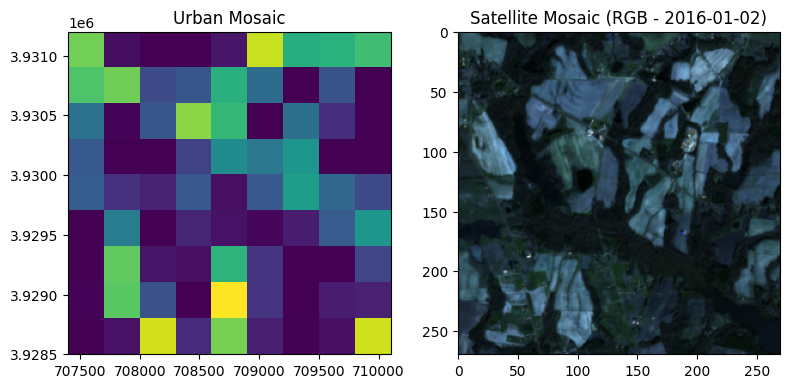

In [81]:
# Paths to the urban data and satellite data directories
urban_data_folder = "../data/urban_gdb"
satellite_data_folder = "../data/tiles_gdb"

# Specific date for the satellite data
specific_date = "2016-01-02"

# Only load files for tile_0 in the urban dataset
urban_tile_files = glob.glob(os.path.join(urban_data_folder, "tile_0_*.tif"))

# List to hold the opened rasterio datasets for the urban data
urban_src_files_to_merge = []

for tif in urban_tile_files:
    src = rasterio.open(tif)
    urban_src_files_to_merge.append(src)

# Perform the merge for the urban mosaic
urban_mosaic, urban_out_trans = merge(urban_src_files_to_merge)

# Select bands B02 (Blue), B03 (Green), B04 (Red) for RGB
rgb_stack = get_mosaics_by_indices([0], tiles_gdf, ['B02', 'B03', 'B04', 'B08'],
                                   "2016-01-01", "2016-02-01")

# Select the bands B02 (Blue), B03 (Green), B04 (Red) for RGB
rgb_stack = rgb_stack.sel(band=["B02", "B03", "B04"])

rgb_array = rgb_stack.isel(time=0)  # Select the first (and only) time step

# Rearrange dimensions for plotting as RGB
rgb_array = rgb_array.transpose('y', 'x', 'band') / rgb_array.max()

# Plot the urban and satellite mosaics side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot the urban mosaic
rasterio.plot.show(urban_mosaic, transform=urban_out_trans, ax=ax1, cmap='viridis')
ax1.set_title("Urban Mosaic")

# Plot the satellite RGB mosaic
ax2.imshow(rgb_array)
ax2.set_title(f"Satellite Mosaic (RGB - {specific_date})")

plt.tight_layout()
plt.show()

In [86]:
def merge_subdivided_tiles(input_tile_dir, output_merged_file):
    """
    Merge all subdivided tiles in the input directory into a single raster file.

    Parameters:
    - input_tile_dir (str): The directory containing the subdivided tiles (.tif files).
    - output_merged_file (str): The path to save the merged raster file.
    """
    # Collect all the .tif files in the input directory
    tile_files = glob.glob(os.path.join(input_tile_dir, "*.tif"))
    
    if not tile_files:
        print(f"No .tif files found in {input_tile_dir}")
        return
    
    # List to hold the opened rasterio datasets
    src_files_to_merge = []

    for tif in tile_files:
        src = rasterio.open(tif)
        src_files_to_merge.append(src)

    # Perform the merge
    mosaic, out_trans = merge(src_files_to_merge)

    # Get metadata from one of the source files
    out_meta = src_files_to_merge[0].meta.copy()

    # Update the metadata to reflect the new dimensions, transform, and CRS
    out_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "count": mosaic.shape[0],  # Update count to match the number of bands in the mosaic
        "dtype": mosaic.dtype  # Make sure the data type is set properly
    })

    # Write the merged raster to disk, ensuring all bands are written correctly
    with rasterio.open(output_merged_file, "w", **out_meta) as dest:
        for i in range(1, mosaic.shape[0] + 1):
            dest.write(mosaic[i - 1], i)

    # Close the opened files
    for src in src_files_to_merge:
        src.close()

    print(f"Merged raster saved to {output_merged_file}")

# Define your parameters
input_tile_dir = "../data/subdivided_urban_tiles_gdb"
output_merged_file = "../data/merged_urban_raster.tif"

if not os.path.exists(output_merged_file):
    # Call the function to merge the subdivided tiles
    merge_subdivided_tiles(input_tile_dir, output_merged_file)

Merged raster saved to ../data/merged_urban_raster.tif


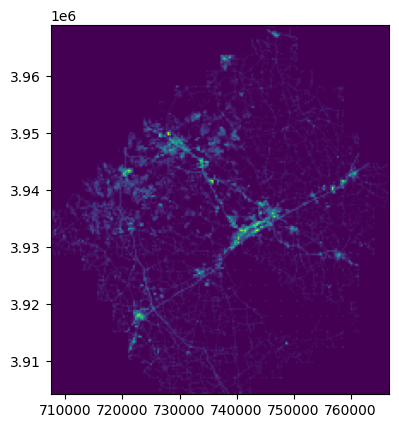

In [87]:
with rasterio.open(output_merged_file) as urban_resampled:
    rasterio.plot.show(urban_resampled, cmap='viridis')

In [ ]:
def get_stack_centroid_lat_lon(stack):
    # Extract the x and y coordinates
    x_coords = stack['x'].values
    y_coords = stack['y'].values
    # Compute the centroid in the dataset's CRS
    x_min = x_coords.min()
    x_max = x_coords.max()
    y_min = y_coords.min()
    y_max = y_coords.max()
    x_centroid = (x_min + x_max) / 2
    y_centroid = (y_min + y_max) / 2
    # Create a GeoDataFrame with the centroid point
    centroid_point = Point(x_centroid, y_centroid)
    gdf = gpd.GeoDataFrame(geometry=[centroid_point], crs=stack.rio.crs)
    # Reproject to WGS84 (EPSG:4326)
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    # Extract latitude and longitude
    lon = gdf_wgs84.geometry.x.values[0]
    lat = gdf_wgs84.geometry.y.values[0]
    return lat, lon

# Use the function on your stack
lat, lon = get_stack_centroid_lat_lon(stack)
print(f'Centroid Latitude: {lat}, Longitude: {lon}')

In [ ]:
# `git clone https://github.com/Clay-foundation/model.git`
# Download clay-v1-base.ckpt from https://huggingface.co/made-with-clay/Clay/tree/main

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ckpt = "../clay-ckpt/clay-v1-base.ckpt"
metadata_path = "../model/configs/metadata.yaml" 
torch.set_default_device(device)

model = ClayMAEModule.load_from_checkpoint(
    ckpt, metadata_path=metadata_path, shuffle=False, mask_ratio=0
)

model.eval()
model = model.to(device)

In [31]:
# Extract mean, std, and wavelengths from metadata
platform = "sentinel-2-l2a"
metadata = Box(yaml.safe_load(open(metadata_path)))
mean = []
std = []
waves = []
# Use the band names to get the correct values in the correct order.
for band in stack.band.values:
    mean.append(metadata[platform].bands.mean[bands_map[str(band)]])
    std.append(metadata[platform].bands.std[bands_map[str(band)]])
    waves.append(metadata[platform].bands.wavelength[bands_map[str(band)]])

# Prepare the normalization transform function using the mean and std values.
transform = v2.Compose(
    [
        v2.Normalize(mean=mean, std=std),
    ]
)

In [33]:
# Prep datetimes embedding using a normalization function from the model code.
def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))


datetimes = stack.time.values.astype("datetime64[s]").tolist()
times = [normalize_timestamp(dat) for dat in datetimes]
week_norm = [dat[0] for dat in times]
hour_norm = [dat[1] for dat in times]

# Prep lat/lon embedding using the
def normalize_latlon(lat, lon):
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

latlons = [normalize_latlon(lat, lon)] * len(times)
lat_norm = [dat[0] for dat in latlons]
lon_norm = [dat[1] for dat in latlons]

# Normalize pixels
pixels = torch.from_numpy(stack.data.astype(np.float32))
pixels = transform(pixels)

In [34]:
# Prepare additional information
datacube = {
    "platform": platform,
    "time": torch.tensor(
        np.hstack((week_norm, hour_norm)),
        dtype=torch.float32,
        device=device,
    ),
    "latlon": torch.tensor(
        np.hstack((lat_norm, lon_norm)), 
        dtype=torch.float32, device=device
    ),
    "pixels": pixels.to(device),
    "gsd": torch.tensor(0.6, device=device),
    "waves": torch.tensor(waves, device=device),
}

In [ ]:
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

# The first embedding is the class token, which is the
# overall single embedding. We extract that for PCA below.
embeddings = unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
# Run PCA
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(embeddings)

plt.xticks(rotation=-45)

plt.scatter(stack.time, pca_result, color="green")
